In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import matplotlib.pyplot as plt
import json
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

# %matplotlib inline
# np.set_printoptions(precision=7)
# %load_ext autoreload
# %autoreload 2

from sklearn.metrics import confusion_matrix, classification_report

In [11]:
batch_size = 100  # The default batch size of keras.
epochs = 2
data_augmentation = False
num_classes=15
#path to where data is stored in github/google drive
data="/content/drive/MyDrive/cfar10_modified_100.npz"

In [4]:
def read_data_from_drive():
  #if data is stored in google drive the next two lines will be nessacary
  from google.colab import drive
  drive.mount('/content/drive')
  data_dict=np.load(data)
  return data_dict

In [5]:
def separate_data(data_dict):
  x_train=data_dict['train']
  y_train=data_dict['ytrain']
  x_test=data_dict['test']
  y_test=data_dict['ytest']
  x_validation=data_dict['validation']
  y_validation=data_dict['yvalidation']

  return  x_train, y_train,x_test,y_test,x_validation,y_validation
  
  
  
  

In [6]:
def prepare_for_model():
  data_dict=read_data_from_drive()
  x_train, y_train,x_test,y_test,x_validation,y_validation=separate_data(data_dict)

  y_train = y_train.astype(np.int16)
  y_test = y_test.astype(np.int16)
  y_validation = y_validation.astype(np.int16)

  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  y_validation = keras.utils.to_categorical(y_validation, num_classes)

  print('x train shape:',x_train.shape)
  print('x_test shape:',x_test.shape)
  print('x_validation shape:',x_validation.shape)

  print('y train shape:',y_train.shape)
  print('y_test shape:',y_test.shape)
  print('y_validation shape:',y_validation.shape)
  return  x_train, y_train,x_test,y_test,x_validation,y_validation


In [7]:
x_train, y_train,x_test,y_test,x_validation,y_validation=prepare_for_model()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
x train shape: (52275, 32, 32, 3)
x_test shape: (11250, 32, 32, 3)
x_validation shape: (11475, 32, 32, 3)
y train shape: (52275, 30)
y_test shape: (11250, 30)
y_validation shape: (11475, 30)


In [13]:
def print_params(model):  
    def count_params(weights):
        """Count the total number of scalars composing the weights.
        # Arguments
            weights: An iterable containing the weights on which to compute params
        # Returns
            The total number of scalars composing the weights
        """
        weight_ids = set()
        total = 0
        for w in weights:
            if id(w) not in weight_ids:
                weight_ids.add(id(w))
                total += int(K.count_params(w))
        return total
    
    trainable_count = count_params(model.trainable_weights)
    non_trainable_count = count_params(model.non_trainable_weights)
    
    print('id\ttrainable : layer name')
    print('-------------------------------')
    for i, layer in enumerate(model.layers):
        print(i,'\t',layer.trainable,'\t  :',layer.name)
    print('-------------------------------')

    print('Total params: {:,}'.format(trainable_count + non_trainable_count))
    print('Trainable params: {:,}'.format(trainable_count))
    print('Non-trainable params: {:,}'.format(non_trainable_count))

In [9]:
def build_model(name, weights='imagenet', cut_at=-1, unfreeze_from=0, opt='adam'):
    
    # load model
    model = VGG16(weights=weights, include_top=False, input_shape=(32,32,3))
    
    # freeze all layer
    for layer in model.layers:
        layer.trainable = False
    
    # select layer output
    if cut_at==-1:
        x = model.output
    else:
        x = model.layers[cut_at].output
        
    # add new classifier head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(30, activation='softmax')(x)

    # instantiate new model
    myModel = Model(inputs=model.input, outputs=predictions, name=name)
        
    # unfreeze selected layer
    for layer in myModel.layers[unfreeze_from:]:
        layer.trainable = True
          
    # compile model
    myModel.compile(
          loss='categorical_crossentropy',
          optimizer=opt, 
          metrics=['accuracy']
    )
          
    # print parameters
    print_params(myModel)
    
    return myModel


In [14]:
model1 = build_model('mini_all', cut_at=13, weights='imagenet')
history1= model1.fit(
    x_train, y_train, 
    validation_data=(x_validation, y_validation), 
    batch_size=batch_size, 
    epochs=epochs, 
    
)

id	trainable : layer name
-------------------------------
0 	 True 	  : input_3
1 	 True 	  : block1_conv1
2 	 True 	  : block1_conv2
3 	 True 	  : block1_pool
4 	 True 	  : block2_conv1
5 	 True 	  : block2_conv2
6 	 True 	  : block2_pool
7 	 True 	  : block3_conv1
8 	 True 	  : block3_conv2
9 	 True 	  : block3_conv3
10 	 True 	  : block3_pool
11 	 True 	  : block4_conv1
12 	 True 	  : block4_conv2
13 	 True 	  : block4_conv3
14 	 True 	  : global_average_pooling2d_2
15 	 True 	  : dense_6
16 	 True 	  : dense_7
17 	 True 	  : dense_8
-------------------------------
Total params: 8,175,966
Trainable params: 8,175,966
Non-trainable params: 0
Epoch 1/2
523/523 [==============================] - 33s 39ms/step - loss: 2.1137 - accuracy: 0.2665 - val_loss: 1.5694 - val_accuracy: 0.4614
Epoch 2/2
523/523 [==============================] - 20s 37ms/step - loss: 1.3276 - accuracy: 0.5587 - val_loss: 1.2575 - val_accuracy: 0.6007


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


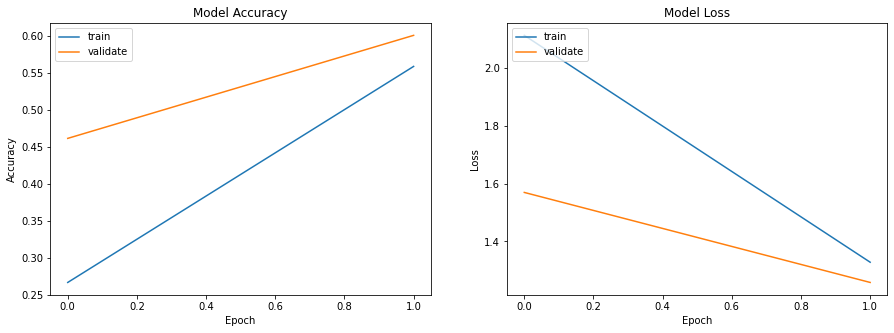

In [15]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history1.history.keys())

plotmodelhistory(history1)


In [16]:
# Score trained model.
scores1 = model1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores1[0])
print('Test accuracy:', scores1[1])

352/352 [==============================] - 3s 8ms/step - loss: 1.2700 - accuracy: 0.6008
Test loss: 1.2700226306915283
Test accuracy: 0.6007999777793884


In [ ]:
#give path of where you wanna store the data- github/google drive

save_dir =  '/content/drive/MyDrive/saved_models'
model_name = 'keras_cifar10_transfer_learning_model1.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model1.save(model_path)
print('Saved trained model at %s ' % model_path)


In [ ]:
pd.DataFrame(history1.history).to_csv('/content/drive/MyDrive/saved_models/history_transfer_learning1.csv')


In [17]:
model2 = build_model('full_all', weights='imagenet')

id	trainable : layer name
-------------------------------
0 	 True 	  : input_4
1 	 True 	  : block1_conv1
2 	 True 	  : block1_conv2
3 	 True 	  : block1_pool
4 	 True 	  : block2_conv1
5 	 True 	  : block2_conv2
6 	 True 	  : block2_pool
7 	 True 	  : block3_conv1
8 	 True 	  : block3_conv2
9 	 True 	  : block3_conv3
10 	 True 	  : block3_pool
11 	 True 	  : block4_conv1
12 	 True 	  : block4_conv2
13 	 True 	  : block4_conv3
14 	 True 	  : block4_pool
15 	 True 	  : block5_conv1
16 	 True 	  : block5_conv2
17 	 True 	  : block5_conv3
18 	 True 	  : block5_pool
19 	 True 	  : global_average_pooling2d_3
20 	 True 	  : dense_9
21 	 True 	  : dense_10
22 	 True 	  : dense_11
-------------------------------
Total params: 15,255,390
Trainable params: 15,255,390
Non-trainable params: 0


In [19]:
history2 = model2.fit(
   x_train, y_train, 
    validation_data=(x_validation, y_validation), 
    batch_size=batch_size, 
    epochs=epochs
)

Epoch 1/2
523/523 [==============================] - 30s 54ms/step - loss: 2.2402 - accuracy: 0.2081 - val_loss: 1.8301 - val_accuracy: 0.3464
Epoch 2/2
523/523 [==============================] - 28s 53ms/step - loss: 1.5644 - accuracy: 0.4612 - val_loss: 1.2987 - val_accuracy: 0.5689


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


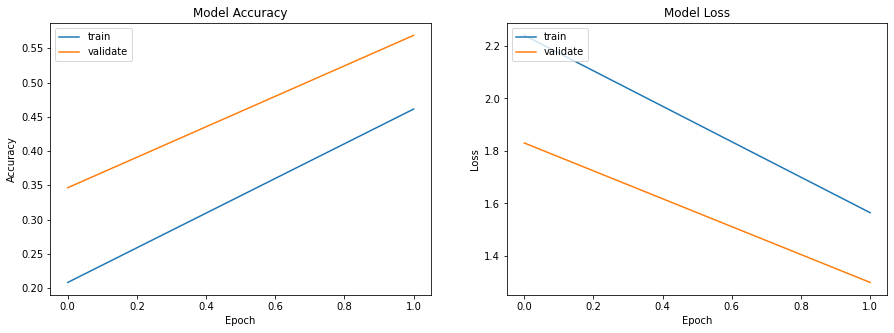

In [21]:

# list all data in history
print(history2.history.keys())

plotmodelhistory(history2)

In [22]:
# Score trained model.
scores2 = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores2[0])
print('Test accuracy:', scores2[1])

352/352 [==============================] - 4s 10ms/step - loss: 1.3069 - accuracy: 0.5603
Test loss: 1.306912899017334
Test accuracy: 0.5602666735649109


In [ ]:
#give path of where you wanna store the data- github/google drive

save_dir =  '/content/drive/MyDrive/saved_models'
model_name = 'keras_cifar10_transfer_learning_model2.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model2.save(model_path)
print('Saved trained model at %s ' % model_path)


In [ ]:
pd.DataFrame(history2.history).to_csv('/content/drive/MyDrive/saved_models/history_transfer_learning2.csv')
